# Custom derived quantities
This notebook demonstrates how to extent MIKE IO 1D with your own reuseable derived quantity.

#### 1 - Exploratory design of the derived quantity

In [1]:
# Let's open a Res1D file.
from mikeio1d import Res1D
res = Res1D("../tests/testdata/network.res1d")
res

<mikeio1d.Res1D>

<Axes: xlabel='Time', ylabel='Water level [$\\mathrm{m}$]'>

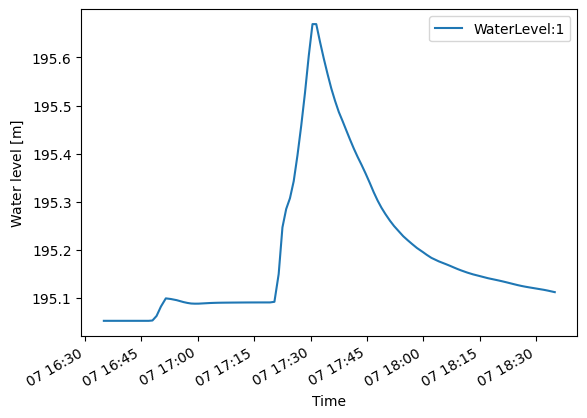

In [2]:
# We will make a derived quantity that detects instabilities in discharge. Let's first read the discharge at a sample point.
res.nodes['1'].WaterLevel.plot()

<Axes: >

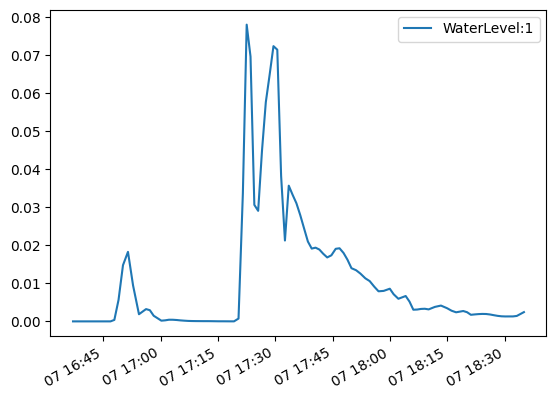

In [3]:
# We'll use a simple approach of taking the rolling standard deviation as an indicator of instability.
df = res.nodes['1'].WaterLevel.read()
df.rolling(3).std().plot()

In [4]:
# Let's find the node with the highest instability per out definition.
(
    res.nodes.WaterLevel.read()
    .rolling(3)
    .std()
    .max()
    .idxmax()
)

'WaterLevel:Weir Outlet:119w1'

<Axes: xlabel='Time', ylabel='Water level [$\\mathrm{m}$]'>

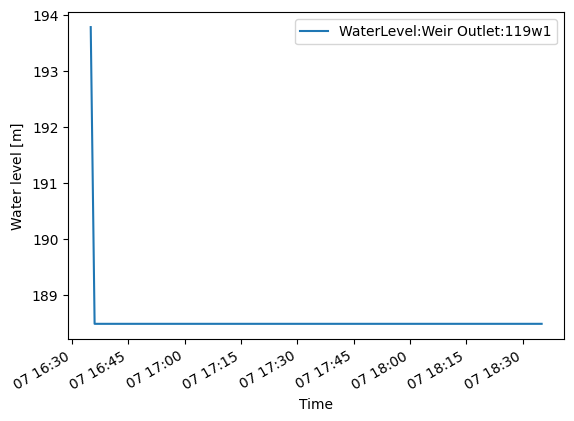

In [5]:
# Let's plot the node found to have the highest instability. Indeed, we found something fishy.
res.nodes['Weir Outlet:119w1'].WaterLevel.plot()

#### 2 - Create a reuseable derived quantity

In [6]:
# We'll need some imports
from mikeio1d.quantities import DerivedQuantity
from mikeio1d.quantities import TimeSeriesIdGroup

In [7]:
# Now let's build our derived quantity. For that, we need to create a class that inherits from DerivedQuantity.

class NodeWaterLevelInstability(DerivedQuantity):
    # This is the name of our derived quantity
    _NAME = "NodeWaterLevelInstability"
    # These are the groups the quantity belongs to. Since we're looking at nodes, we put it in the NODE group.
    _GROUPS = {TimeSeriesIdGroup.NODE}
    # This is the actual quantity we're deriving from. In this case, it's the water level.
    _SOURCE_QUANTITY = "WaterLevel"

    # This contains the logic we created in the last step.
    def derive(self, df_source, locations):
        return df_source.rolling(3).std()

In [8]:
# We need to tell MIKE IO 1D that we have a new derived quantity.
from mikeio1d.res1d import derived_quantity_manager as dqm
dqm.register(NodeWaterLevelInstability)

#### 3 - Test our new derived quantity

In [9]:
# We need to reload our result file.
res = Res1D("../tests/testdata/network.res1d")
res

<mikeio1d.Res1D>

In [10]:
# Let's check out the node we know to be instable. Notice our new derived quantity is listed in the repr below.
instable_node = res.nodes['Weir Outlet:119w1']
instable_node

<Outlet: Weir Outlet:119w1>

<Axes: xlabel='Time', ylabel='NodeWaterLevelInstability'>

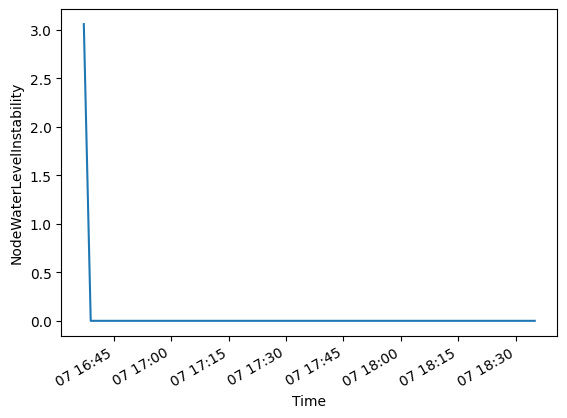

In [11]:
# Let's plot the derived quantity. It looks reasonable.
instable_node.NodeWaterLevelInstability.plot(legend=False)

In [12]:
# Let's read the derived quantity for all nodes.
res.nodes.NodeWaterLevelInstability.read().head(5)

quantity                NodeWaterLevelInstability                           \
group                                        Node                            
name                                            1         2    3    4    5   
1994-08-07 16:35:00.000                       NaN       NaN  NaN  NaN  NaN   
1994-08-07 16:36:01.870                       NaN       NaN  NaN  NaN  NaN   
1994-08-07 16:37:07.560                       0.0  0.000102  0.0  0.0  0.0   
1994-08-07 16:38:55.828                       0.0  0.000102  0.0  0.0  0.0   
1994-08-07 16:39:55.828                       0.0  0.000079  0.0  0.0  0.0   

quantity                                                              ...  \
group                                                                 ...   
name                            6         7         8         9   10  ...   
1994-08-07 16:35:00.000       NaN       NaN       NaN       NaN  NaN  ...   
1994-08-07 16:36:01.870       NaN       NaN       NaN       NaN  NaN  ...   
1994-08-07 16:37:07.560  0.000336  0.000188  0.000054  0.000271  0.0  ...   
1994-08-07 16:38:55.828  0.000462  0.000322  0.000087  0.000483  0.0  ...   
1994-08-07 16:39:55.828  0.000448  0.000295  0.000115  0.000428  0.0  ...   

quantity                                                                   \
group                                                                       
name                      46   55        58       116       117       118   
1994-08-07 16:35:00.000  NaN  NaN       NaN       NaN       NaN       NaN   
1994-08-07 16:36:01.870  NaN  NaN       NaN       NaN       NaN       NaN   
1994-08-07 16:37:07.560  0.0  0.0  0.000047  0.000054  0.000713  0.001599   
1994-08-07 16:38:55.828  0.0  0.0  0.000085  0.000046  0.000565  0.001450   
1994-08-07 16:39:55.828  0.0  0.0  0.000092  0.000032  0.000361  0.001092   

quantity                                                            
group                                                               
name                          115       119  120 Weir Outlet:119w1  
1994-08-07 16:35:00.000       NaN       NaN  NaN               NaN  
1994-08-07 16:36:01.870       NaN       NaN  NaN               NaN  
1994-08-07 16:37:07.560  0.001076  0.000018  0.0          3.059958  
1994-08-07 16:38:55.828  0.001424  0.000038  0.0          0.000000  
1994-08-07 16:39:55.828  0.001376  0.000032  0.0          0.000000  

[5 rows x 119 columns]